# Evaluating a classification model ([video #9](https://www.youtube.com/watch?v=85dtiMz9tSo&list=PL5-da3qGB5ICeMbQuqbbCOQWcS6OYBr5A&index=9))

Created by [Data School](https://www.dataschool.io). Watch all 10 videos on [YouTube](https://www.youtube.com/playlist?list=PL5-da3qGB5ICeMbQuqbbCOQWcS6OYBr5A). Download the notebooks from [GitHub](https://github.com/justmarkham/scikit-learn-videos).

**Note:** This notebook uses Python 3.9.1 and scikit-learn 0.23.2. The original notebook (shown in the video) used Python 2.7 and scikit-learn 0.16.

## Agenda

- What is the purpose of **model evaluation**, and what are some common evaluation procedures?
- What is the usage of **classification accuracy**, and what are its limitations?
- How does a **confusion matrix** describe the performance of a classifier?
- What **metrics** can be computed from a confusion matrix?
- How can you adjust classifier performance by **changing the classification threshold**?
- What is the purpose of an **ROC curve**?
- How does **Area Under the Curve (AUC)** differ from classification accuracy?

## Review of model evaluation

- Need a way to choose between models: different model types, tuning parameters, and features
- Use a **model evaluation procedure** to estimate how well a model will generalize to out-of-sample data
- Requires a **model evaluation metric** to quantify the model performance

### Model evaluation procedures (In order of worse to best)

K-fold is the best. However Train/Test split is still used/preferred in a lot of cases due to its speed and accuracy and hence we will use it here

1. **Training and testing on the same data**
    - Rewards overly complex models that "overfit" the training data and won't necessarily generalize
2. **Train/test split**
    - Split the dataset into two pieces, so that the model can be trained and tested on different data
    - Better estimate of out-of-sample performance, but still a "high variance" estimate
    - Useful due to its speed, simplicity, and flexibility
3. **K-fold cross-validation**
    - Systematically create "K" train/test splits and average the results together
    - Even better estimate of out-of-sample performance
    - Runs "K" times slower than train/test split

### Model evaluation metrics - The choice of metric depend on the type of problem at hand

- **Regression problems:** Mean Absolute Error, Mean Squared Error, Root Mean Squared Error
- **Classification problems:** Classification accuracy

## Classification accuracy

[Pima Indians Diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database) originally from the UCI Machine Learning Repository

In [1]:
# added empty cell so that the cell numbering matches the video

In [1]:
# read the data into a pandas DataFrame
import pandas as pd
path = 'data/pima-indians-diabetes.data'
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
pima = pd.read_csv(path, header=None, names=col_names)

In [2]:
# print the first 5 rows of data
pima.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Data Understanding:** label = 0 means person has no diabetes. label = 1 means person has diabetes

**Question:** Can we predict the diabetes status of a patient given their health measurements?

In [3]:
# define X and y : independant and depedant variables
feature_cols = ['pregnant', 'insulin', 'bmi', 'age']
X = pima[feature_cols]
y = pima.label

In [4]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [5]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear')

#logreg here is learning the relationship between X_train and y_train
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [6]:
# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

**Classification accuracy:** percentage of correct predictions

In [7]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.6927083333333334


Can we trust classification accuracy? Let's test Null accuracy i.e no model usage

**Null accuracy:** accuracy that could be achieved by always predicting the most frequent class

In [8]:
# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

0    130
1     62
Name: label, dtype: int64

**In the given data: we have NOT diabetic(0) as 130 times. If we simply predict ALL 0 (not diabetic) then what's our accuracy?**

In [9]:
# calculate the percentage of ones
y_test.mean()

0.3229166666666667

This tells us that **32%** of the values in our data are 1 (is diabetic)

In [10]:
# calculate the percentage of zeros
1 - y_test.mean()

0.6770833333333333

**68%** are 0s (diabetic)

In [12]:
# calculate null accuracy (for binary classification problems coded as 0/1) in a single line of code
max(y_test.mean(), 1 - y_test.mean()) 

0.6770833333333333

**68% in null accuracy: A DUMB model that always predicts that the patient will be diabetic will be right 68% of the time**

Why is this happening? Because we have a lot of 0s in our data and we're predicting all as 0s. That's why they're accidentally accurate but this is a kind of error

Now when we compare this accuracy(taking this as a benchmark) to our model accuracy which is **67%**, our model doesn't look good

The above formula/approach only works for binary classification so we need a different formula for multi-classification

In [13]:
# calculate null accuracy (for multi-class classification problems)
y_test.value_counts().head(1) / len(y_test)

0    0.677083
Name: label, dtype: float64

Comparing the **true** and **predicted** response values

In [14]:
# print the first 25 true and predicted responses
print('True:', y_test.values[0:25])
print('Pred:', y_pred_class[0:25])

True: [1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0]
Pred: [0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


Observation : When predicted value is 0, actual value is always 0, when predicted value are 1, sometimes it is 1 and sometimes it's not. We wouldn't know this without looking deep. This also suggests that there is a CERTAIN TYPE of error in our model.

How to know the types/solution: **Confusion Matrix**

**Conclusion:**

- Classification accuracy is the **easiest classification metric to understand**
- But, it does not tell you the **underlying distribution** of response values
- And, it does not tell you what **"types" of errors** your classifier is making

## Confusion matrix

Table that describes the performance of a classification model

In [10]:
# IMPORTANT: first argument is true values, second argument is predicted values
print(metrics.confusion_matrix(y_test, y_pred_class))

[[118  12]
 [ 47  15]]


![Small confusion matrix](images/09_confusion_matrix_1.png)

- Every observation in the testing set is represented in **exactly one box**
- It's a 2x2 matrix because there are **2 response classes**
- The format shown here is **not** universal

**Basic terminology**

- **True Positives (TP):** we *correctly* predicted that they *do* have diabetes
- **True Negatives (TN):** we *correctly* predicted that they *don't* have diabetes
- **False Positives (FP):** we *incorrectly* predicted that they *do* have diabetes (a "Type I error")
- **False Negatives (FN):** we *incorrectly* predicted that they *don't* have diabetes (a "Type II error")

In [11]:
# print the first 25 true and predicted responses
print('True:', y_test.values[0:25])
print('Pred:', y_pred_class[0:25])

True: [1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0]
Pred: [0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [12]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

![Large confusion matrix](images/09_confusion_matrix_2.png)

We have learnt that we cannot rely just on confusion matrix. However, we can compute a lot of matrics from a confusion matrix using which we can derive some insights/make our model better

## Metrics computed from a confusion matrix

**Classification Accuracy:** Overall, how often is the classifier correct?

In [13]:
print((TP + TN) / (TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.6927083333333334
0.6927083333333334


**Classification Error:** Overall, how often is the classifier incorrect? **1 - accuracy**

- Also known as "Misclassification Rate"

In [14]:
print((FP + FN) / (TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.3072916666666667
0.30729166666666663


**Sensitivity:** When the actual value is positive, how often is the prediction correct? (Only refer to second ROW)

- How "sensitive" is the classifier to detecting positive instances?
- Also known as "True Positive Rate" or "Recall"

In [22]:
print(TP / (TP + FN))
print(metrics.recall_score(y_test, y_pred_class))

0.24193548387096775
0.24193548387096775


**Specificity:** When the actual value is negative, how often is the prediction correct? (Only refer to first ROW) **(We want to maximize this)**

- How "specific" (or "selective") is the classifier in predicting positive instances?

In [15]:
print(TN / (TN + FP))

0.9076923076923077


**False Positive Rate:** When the actual value is negative, how often is the prediction incorrect? **(1- specificity)**

In [24]:
print(FP / (TN + FP))

0.09230769230769231


**Precision:** When a positive value is predicted, how often is the prediction correct?

- How "precise" is the classifier when predicting positive instances?

In [25]:
print(TP / (TP + FP))
print(metrics.precision_score(y_test, y_pred_class))

0.5555555555555556
0.5555555555555556


Many other metrics can be computed: F1 score, Matthews correlation coefficient, etc.

**Conclusion:**

- Confusion matrix gives you a **more complete picture** of how your classifier is performing
- Also allows you to compute various **classification metrics**, and these metrics can guide your model selection

**Which metrics should you focus on?**

- Choice of metric depends on your **business objective**
- **Spam filter** (positive class is "spam"): Optimize for **precision or specificity** because false negatives (spam goes to the inbox) are more acceptable than false positives (non-spam is caught by the spam filter)
- **Fraudulent transaction detector** (positive class is "fraud"): Optimize for **sensitivity** because false positives (normal transactions that are flagged as possible fraud) are more acceptable than false negatives (fraudulent transactions that are not detected)

# NEXT Q: HOW TO ADJUST THE PERFORMANCE OF CLASSIFIERS?

## Adjusting the classification threshold

In [16]:
# print the first 10 predicted responses
logreg.predict(X_test)[0:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1], dtype=int64)

In [17]:
# print the first 10 predicted probabilities of class membership
logreg.predict_proba(X_test)[0:10, :]

array([[0.63247571, 0.36752429],
       [0.71643656, 0.28356344],
       [0.71104114, 0.28895886],
       [0.5858938 , 0.4141062 ],
       [0.84103973, 0.15896027],
       [0.82934844, 0.17065156],
       [0.50110974, 0.49889026],
       [0.48658459, 0.51341541],
       [0.72321388, 0.27678612],
       [0.32810562, 0.67189438]])

### [0 , 1]  [Predicted Probability that each observation is a member of class 0, Predicted Probability that each observation is a member of class 1]

In [19]:
# print the first 10 predicted probabilities for class 1
logreg.predict_proba(X_test)[0:10, 1]

array([0.36752429, 0.28356344, 0.28895886, 0.4141062 , 0.15896027,
       0.17065156, 0.49889026, 0.51341541, 0.27678612, 0.67189438])

We just took first 10 for understanding. We'll take now all values

In [20]:
# store the predicted probabilities for class 1
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

### We'll plot a histogram of these probabilities to demonstrate how adjusting the classification threshold can impact the performance of the model 

In [21]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

Text(0, 0.5, 'Frequency')

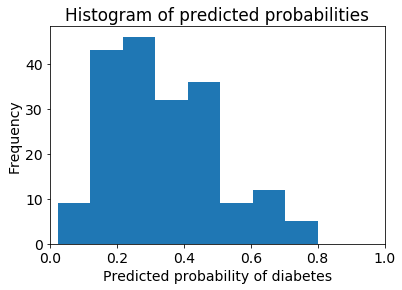

In [22]:
# histogram of predicted probabilities
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

**Shows us distribution of numerical data**

Observation 1 : Between 0.2 to 0.3 probability we have 45 values/rows in data

Observation 2 : Just by looking at the graph, we can see that barely any predicted values are above 0.5 so if we take into our model that **below 0.5 threshold is 0/not diabetic**, then class 1 will be rarely predicted

What might happen if we change our threshold to a number other than 0.5. If we decrease the threshold to 0.3, it will predict 1 more often. Think about our use-case here, a person could have unhealthy metrics but we are hardly predicting anyone diabetic, so if we decrease the threshold to 0.3, we can show more people are diabetic and then treat them accordingly

**Decrease the threshold** for predicting diabetes in order to **increase the sensitivity** of the classifier

In [26]:
# predict diabetes if the predicted probability is greater than 0.3
from sklearn.preprocessing import binarize
#Binarise function will return 1 for all values above 0.3 and 0 for all values below 1
y_pred_class = binarize([y_pred_prob], threshold=0.3)[0]

Previous Result of Logistic Regression : Note only 2 will be classified as 1 based on 0.5

In [27]:
# print the first 10 predicted probabilities
y_pred_prob[0:10]

array([0.36752429, 0.28356344, 0.28895886, 0.4141062 , 0.15896027,
       0.17065156, 0.49889026, 0.51341541, 0.27678612, 0.67189438])

New Result with adjusted threshold: Much more are classified as 1 (diabetic) because we now took the threshold as 0.3

In [28]:
# print the first 10 predicted classes with the lower threshold
y_pred_class[0:10]

array([1., 0., 0., 1., 0., 0., 1., 1., 0., 1.])

In [29]:
# previous confusion matrix (default threshold of 0.5)
print(confusion)

[[118  12]
 [ 47  15]]


In [30]:
# new confusion matrix (threshold of 0.3)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[80 50]
 [16 46]]


In [31]:
# sensitivity has increased (used to be 0.24)
print(46 / (46 + 16))

0.7419354838709677


In [32]:
# specificity has decreased (used to be 0.91)
print(80 / (80 + 50))

0.6153846153846154


**Conclusion:**

- **Threshold of 0.5** is used by default (for binary problems) to convert predicted probabilities into class predictions
- Threshold can be **adjusted** to increase sensitivity or specificity
- Sensitivity and specificity have an **inverse relationship**

**What we did so far**:

- We ran a logistic regression model to predict whether a patient is diabetic or not
- We then ran confusion matrix on it to see accuracy
- We then saw that confusion matrix is not enough to see accuracy
- A good idea then was to plot a histogram of predicted probabilities as in where they lie: We saw that very few lie above 0.5. So if we proceed with 0.5 default threshold, a lot of unhealthy patients might not be classified as diabetic.
- We then changed the threshold to 0.3 and to see how many more are now classified as diabetic. Now there are some jargon terms to measure this: senstivity etc.


NOTE: We manually chose 0.3. Could there be a SMARTER way to pick this?

----

## ROC Curves and Area Under the Curve (AUC)

**Question:** Wouldn't it be nice if we could see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold?

**Answer:** Plot the ROC curve!

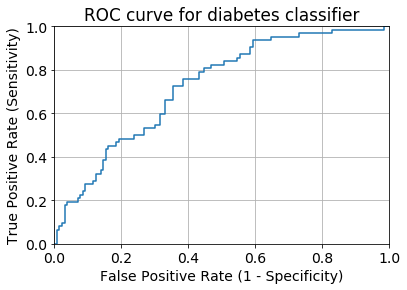

In [36]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

**What this tells us/How to read** : If you want to achieve a senstivity of 0.8, you'll have to accept the specificty as 0.6(1 - 0.4)

- ROC curve can help you to **choose a threshold** that balances sensitivity and specificity in a way that makes sense for your particular context
- You can't actually **see the thresholds** used to generate the curve on the ROC curve itself

In [37]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [38]:
evaluate_threshold(0.5)

Sensitivity: 0.24193548387096775
Specificity: 0.9076923076923077


In [39]:
evaluate_threshold(0.3)

Sensitivity: 0.7258064516129032
Specificity: 0.6153846153846154


## AUC is the **percentage** of the ROC plot that is **underneath the curve**:

### Higher AUC value is indicative of a better overall classifier. As such, AUC is often used as a single number summary of  the performance of a classfier as an alternative to classifier accuracy

In [40]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.7245657568238213


Best possible AUC is 1

- AUC is useful as a **single number summary** of classifier performance.
- If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a **higher predicted probability** to the positive observation.
- AUC is useful even when there is **high class imbalance** (unlike classification accuracy).

In [49]:
# calculate cross-validated AUC
from sklearn.model_selection import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.7378233618233618

**Confusion matrix advantages:**

- Allows you to calculate a **variety of metrics**
- Useful for **multi-class problems** (more than two response classes) ROC/AUC are less usefull for multi-class problems

**ROC/AUC advantages:**

- Does not require you to **set a classification threshold**
- Still useful when there is **high class imbalance**

## Confusion Matrix Resources

- Blog post: [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by me
- Videos: [Intuitive sensitivity and specificity](https://www.youtube.com/watch?v=U4_3fditnWg) (9 minutes) and [The tradeoff between sensitivity and specificity](https://www.youtube.com/watch?v=vtYDyGGeQyo) (13 minutes) by Rahul Patwari
- Notebook: [How to calculate "expected value"](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb) from a confusion matrix by treating it as a cost-benefit matrix (by Ed Podojil)
- Graphic: How [classification threshold](https://media.amazonwebservices.com/blog/2015/ml_adjust_model_1.png) affects different evaluation metrics (from a [blog post](https://aws.amazon.com/blogs/aws/amazon-machine-learning-make-data-driven-decisions-at-scale/) about Amazon Machine Learning)


## ROC and AUC Resources

- Video: [ROC Curves and Area Under the Curve](https://www.youtube.com/watch?v=OAl6eAyP-yo) (14 minutes) by me, including [transcript and screenshots](https://www.dataschool.io/roc-curves-and-auc-explained/) and a [visualization](http://www.navan.name/roc/)
- Video: [ROC Curves](https://www.youtube.com/watch?v=21Igj5Pr6u4) (12 minutes) by Rahul Patwari
- Paper: [An introduction to ROC analysis](http://people.inf.elte.hu/kiss/13dwhdm/roc.pdf) by Tom Fawcett
- Usage examples: [Comparing different feature sets](https://www.microsoft.com/en-us/research/wp-content/uploads/2013/11/aisec10-leontjeva.pdf) for detecting fraudulent Skype users, and [comparing different classifiers](https://www.cse.ust.hk/nevinZhangGroup/readings/yi/Bradley_PR97.pdf) on a number of popular datasets

## Other Resources

- scikit-learn documentation: [Model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html)
- Guide: [Comparing model evaluation procedures and metrics](https://github.com/justmarkham/DAT8/blob/master/other/model_evaluation_comparison.md) by me
- Video: [Counterfactual evaluation of machine learning models](https://www.youtube.com/watch?v=QWCSxAKR-h0) (45 minutes) about how Stripe evaluates its fraud detection model, including [slides](https://www.slideshare.net/MichaelManapat/counterfactual-evaluation-of-machine-learning-models)

## Comments or Questions?

- Email: <kevin@dataschool.io>
- Website: https://www.dataschool.io
- Twitter: [@justmarkham](https://twitter.com/justmarkham)